# Idealista EDA

In this notebook, we are going to perform a simple explanatory data analysis of the previous cleaned data.

For this dataset, we're going to perform a really basic data analysis to observe:

- How the prices vary across different regions
- How distance to state capital increases or decreases the propety price
- 

First of all, we will load the csv file created on the before notebook (`idealista_clean.csv`).

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/processed/idealista_clean.csv')
df.head()

,propertyCode,thumbnail,numPhotos,floor,price,propertyType,operation,size,exterior,rooms,...,has360,topNewDevelopment,detailedType_typology,suggestedTexts_subtitle,suggestedTexts_title,parkingSpace_hasParkingSpace,parkingSpace_isParkingSpaceIncludedInPrice,detailedType_subTypology,parkingSpace_parkingSpacePrice,spain_state
0,88707408,https://img3.idealista.com/blur/WEB_LISTING/0/...,18,3,1050.0,flat,rent,50.0,True,1,...,False,False,flat,"Sants, Barcelona","Piso en Calle de Sants, 208",False,False,unknown,0.0,Barna
1,90050445,https://img3.idealista.com/blur/WEB_LISTING/0/...,13,5,3000.0,flat,rent,170.0,True,5,...,False,False,flat,"Pedralbes, Barcelona",Piso en Avenida Diagonal,True,True,unknown,0.0,Barna
2,89790054,https://img3.idealista.com/blur/WEB_LISTING/0/...,17,4,1050.0,flat,rent,75.0,True,2,...,False,False,flat,"La Maternitat i Sant Ramon, Barcelona",Piso en Calle del Comandant Benítez,False,False,unknown,0.0,Barna
3,89813394,https://img3.idealista.com/blur/WEB_LISTING/0/...,16,3,780.0,studio,rent,36.0,True,0,...,False,False,flat,"La Maternitat i Sant Ramon, Barcelona",Estudio,False,False,studio,0.0,Barna
4,90050238,https://img3.idealista.com/blur/WEB_LISTING/0/...,14,1,725.0,flat,rent,65.0,True,2,...,False,False,flat,"Sant Ildefons, Cornellà de Llobregat",Piso en boix,False,False,unknown,0.0,Barna


## Price analysis

### Price by province

If we take a look on this current dataset, each flat corresponds a unique city. The idea is calculate the average by city in order to get the average price for renting a flat. For instance, actually the flats in Barcelona are more expensive than Lleida.

In [3]:
data = df.groupby('spain_state')['price'].mean()
data = data.sort_values(ascending=False)
data

spain_state
Barna        1690.924000
Mallorca     1653.446667
Madrid       1570.425000
Valencia     1116.566316
Malaga        927.935714
Tarragona     856.175000
Girona        817.088353
Zaragoza      718.464286
Lleida        653.810811
Name: price, dtype: float64

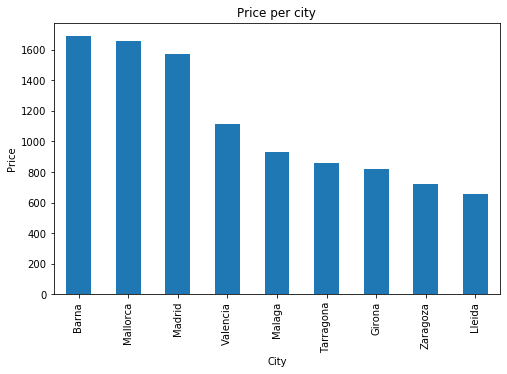

In [4]:
plt.title('Price per city')
data.plot.bar(figsize=(8, 5))
plt.xlabel('City')
plt.ylabel('Price');

We can take the comparison a setp further and compare the distributions for each state.

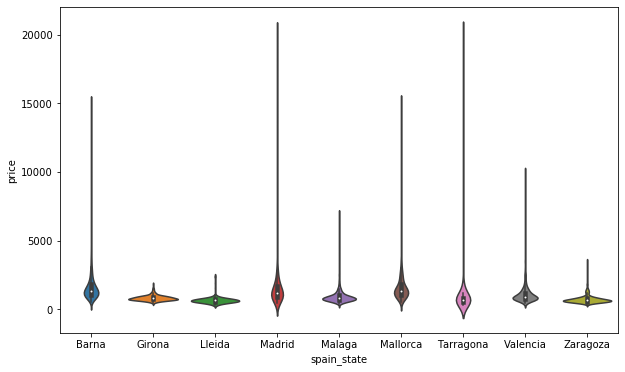

In [5]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='spain_state', y='price', data=df[['spain_state', 'price']]);

For most of the states, the price distributions are not central, they stick around low values, but there are also some properties that are "pulling" the mean up (they are outliers). This means that the most properties in that cities are around the mean of 1000€ but there are some that are really expensive.

This behaviour is observed in big or turistic cities such as: Mallorca, Madrid, Barcelona.

Meanwhile, the common cities which are not as much turistic such as lleida, have a more central distribution, near to a normal one.

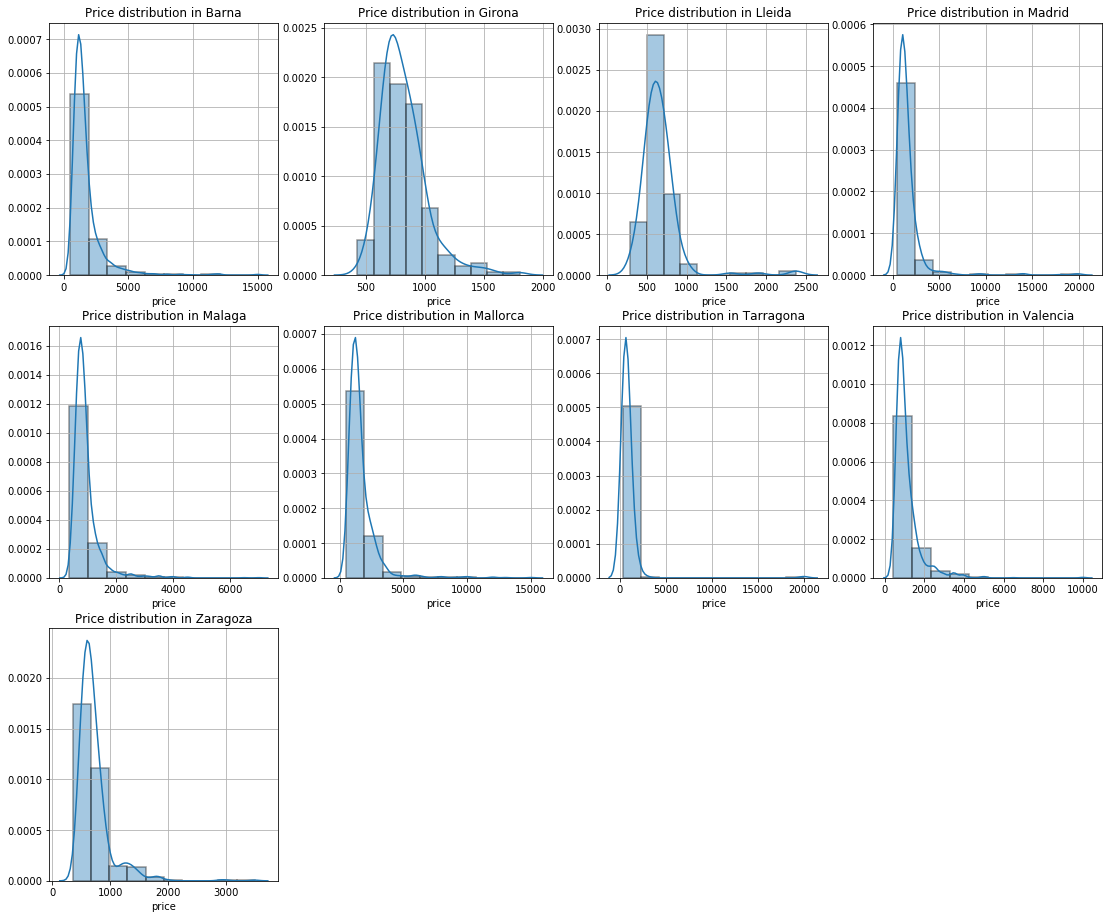

In [6]:
plt.figure(figsize=(15, 15))
n_states = len(df.spain_state.unique())
for i, state in enumerate(df.spain_state.unique(), start=1):
    plt.subplot(n_states // 2, n_states // 2, i)
    plt.title(f'Price distribution in {state}')
    plt.subplots_adjust(right=1.1, top=1.2)
    sns.distplot(df[df.spain_state == state].price,
                 bins=10,
                 hist_kws=dict(edgecolor='black', linewidth=1.5))
    plt.grid('on')

In [7]:
central_stats = dict()
for state in df.spain_state.unique():
    mean = df[df.spain_state == state].price.mean()
    std = df[df.spain_state == state].price.std()
    median = df[df.spain_state == state].price.median()
    central_stats[state] = dict(mean=mean, std=std, median=median)
central_stats_df = pd.DataFrame(central_stats)

Lleida and Zaragoza is where the rent price is the lowest, while the highest prices are in Barcelona, Madrid and Mallorca.

Also as expected, turistic cities as Mallorca has a higher standard deviation, this is beacuse there are flats that are thought for daily life, while others are thought for holidays. These last ones are more expensive.

### Price by state and area

In this section we repeat the previous analysis but using the price per $m^2$ because this is more accurate when comparing multiple properties. For instance, in the previous section, we were puting flats of around 

In [8]:
data = df.groupby('spain_state')['priceByArea'].mean()
data = data.sort_values(ascending=False)
data

spain_state
Barna        17.984400
Madrid       15.996250
Mallorca     12.766667
Malaga       10.953333
Valencia     10.698421
Girona        9.594378
Tarragona     8.815000
Zaragoza      8.700000
Lleida        7.048649
Name: priceByArea, dtype: float64

We can see that the trend is the same as the previous plots.

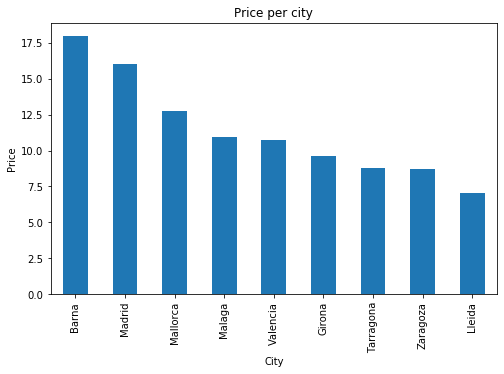

In [9]:
plt.title('Price per city')
data.plot.bar(figsize=(8, 5))
plt.xlabel('City')
plt.ylabel('Price');

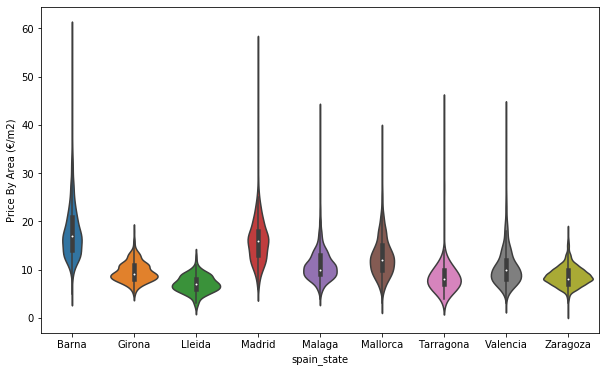

In [10]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='spain_state', y='priceByArea', data=df[['spain_state', 'priceByArea']])
plt.ylabel('Price By Area (€/m2)')
plt.show()

### Average price by type of property

As we know the propierties on sale that appear on idealista can be too different. For instance, on the next part we can see the different types of propierties that exists on this dataset. Each one could be very different than other and this also affect on your price.

In [11]:
central_stats = dict()
for prop_type in df.propertyType.unique():
    mean = df[df.propertyType == prop_type].priceByArea.mean()
    std = df[df.propertyType == prop_type].priceByArea.std()
    median = df[df.propertyType == prop_type].priceByArea.median()
    central_stats[prop_type] = dict(mean=mean, std=std, median=median)
central_stats_df = pd.DataFrame(central_stats)
central_stats_df

,flat,studio,duplex,penthouse,chalet,countryHouse
mean,12.810521,16.811377,13.114407,14.674617,10.160891,9.818182
std,5.384561,5.745116,5.425672,6.299257,4.969521,7.305042
median,12.000000,16.000000,12.000000,14.000000,9.000000,9.000000


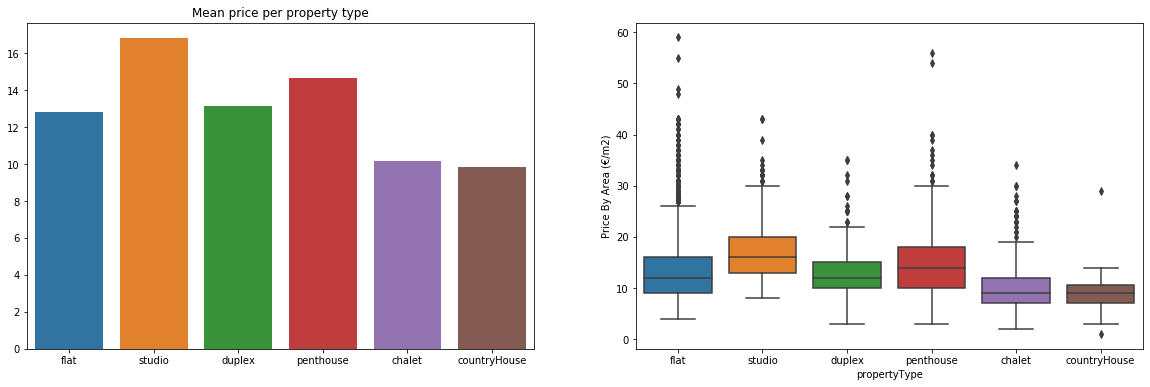

In [12]:
plt.figure(figsize=(20, 6))
plt.subplot(121)

plt.title('Mean price per property type')
sns.barplot(x=central_stats_df.columns, 
            y=central_stats_df.loc['mean'].values)

plt.subplot(122)
sns.boxplot(x="propertyType", y="priceByArea", data=df)
plt.ylabel('Price By Area (€/m2)')
plt.show()

Taking into account that we are comparing by the price by area, not by the total price, we observe that the studios are the most expensive one. Even that, flats has a lot of expensive outliers, probabiliy belonging to more expensive cities such as Mallorca, Barcelona, Madrid, etc.

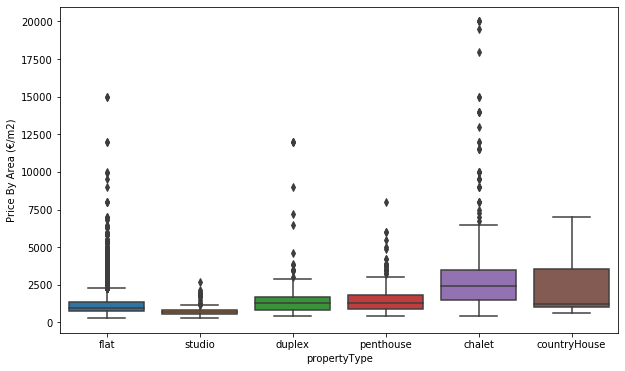

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="propertyType", y="price", data=df)
plt.ylabel('Price By Area (€/m2)')
plt.show()

Comparing the total prices, as expected, we see that the chalets are much more expensive than the other property types, this is because chalets are usually much more larger than other properties.

### Does the distance matter?

The distance column contains the number of meters between that the property and the state capital. In the following cells we are going to see if the distance is correlated to the properties' price.

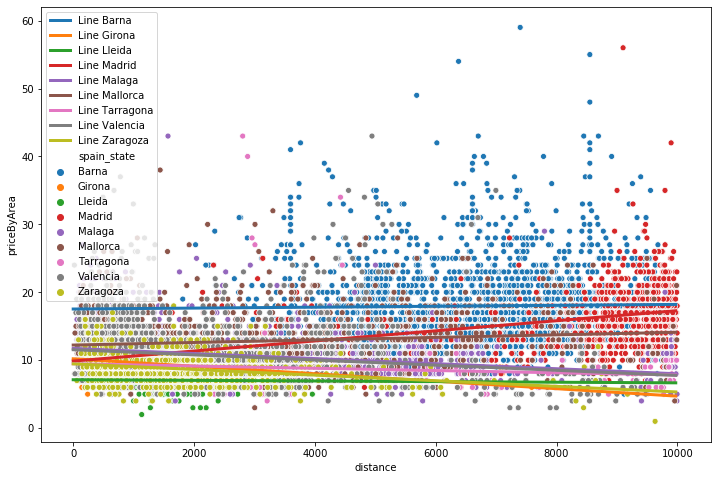

In [14]:
plt.figure(figsize=(12, 8))

for state in df.spain_state.unique():
    mask = df.spain_state == state
    lr = LinearRegression()
    lr.fit(df[mask].distance.values.reshape(-1, 1), 
           df[mask].priceByArea.values.reshape(-1, 1))
    plt.plot(np.arange(df.distance.shape[0]), 
             np.arange(df.distance.shape[0]) * lr.coef_.reshape(-1) + lr.intercept_,
             linewidth=3,
             label=f'Line {state}')
    
sns.scatterplot(x="distance", y="priceByArea", hue='spain_state', data=df)
plt.show()

Depending on the state the correlation of the distance varies.

In [15]:
for state in df.spain_state.unique():
    mask = df.spain_state == state
    corr, _ = scipy.stats.pearsonr(df[mask].distance.values, df[mask].priceByArea.values)
    print(f'Pearson correlation for {state} is {corr:.3f}')

Pearson correlation for Barna is 0.020
Pearson correlation for Girona is -0.275
Pearson correlation for Lleida is -0.014
Pearson correlation for Madrid is 0.350
Pearson correlation for Malaga is -0.236
Pearson correlation for Mallorca is 0.109
Pearson correlation for Tarragona is -0.087
Pearson correlation for Valencia is -0.164
Pearson correlation for Zaragoza is -0.268


The strongest scatter plot is the one resulting from Madrid. While the scater plot with less correlation is from Barcelona.

## Rents in numbers

On this dataset, each line corresponds an offer that one property do in order to rent your property to other people who find a rent flat or whatever. If we take into that our dataset is composed by offers on the most important cities in our country, we can see what type of flat is the most sold.

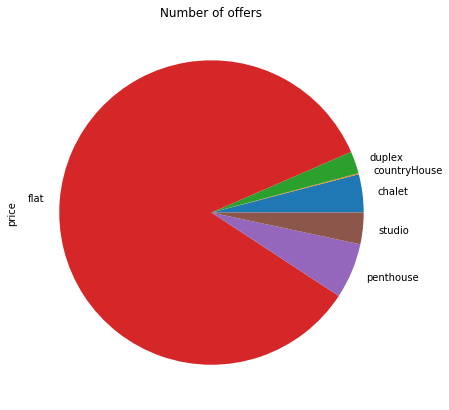

In [16]:
data = df.groupby('propertyType')['price'].count()
plt.subplots(figsize=(10,7))
plt.title('Number of offers')
data.plot.pie();

## Predective analysis

In [18]:
features_columns = [
    'numPhotos', 'floor', 'propertyType', 'size',
    'exterior', 'rooms', 'bathrooms', 'province',
    'latitude', 'longitude', 'showAddress', 'hasLift',
    'newDevelopment', 'hasPlan', 'has3DTour', 'has360',
    'parkingSpace_hasParkingSpace']
label = 'price'

In [19]:
X = df[features_columns].copy()

In [20]:
def floor_feature_eng(f):
    try:
        return 'high' if int(f) > 8 else 'low'
    except ValueError:
        return 'other'

In [21]:
X['floor'] = X.floor.apply(floor_feature_eng).astype('category')
X['propertyType'] = X.propertyType.astype('category')
X['province'] = X.province.astype('category')

In [22]:
ohe_floor = pd.get_dummies(X['floor'], prefix='floor')
X.drop('floor', axis='columns', inplace=True)
X = pd.concat([X, ohe_floor], axis=1)

ohe_state = pd.get_dummies(X['province'], prefix='province')
X.drop('province', axis='columns', inplace=True)
X = pd.concat([X, ohe_state], axis=1)

ohe_type = pd.get_dummies(X['propertyType'], prefix='type')
X.drop('propertyType', axis='columns', inplace=True)
X = pd.concat([X, ohe_type], axis=1)

X.head()

,numPhotos,size,exterior,rooms,bathrooms,latitude,longitude,showAddress,hasLift,newDevelopment,...,province_Málaga,province_Tarragona,province_València,province_Zaragoza,type_chalet,type_countryHouse,type_duplex,type_flat,type_penthouse,type_studio
0,18,50.0,True,1,1,41.375655,2.131254,True,True,False,...,0,0,0,0,0,0,0,1,0,0
1,13,170.0,True,5,2,41.383894,2.109505,False,True,False,...,0,0,0,0,0,0,0,1,0,0
2,17,75.0,True,2,1,41.378574,2.125388,False,True,False,...,0,0,0,0,0,0,0,1,0,0
3,16,36.0,True,0,1,41.374159,2.114336,False,False,False,...,0,0,0,0,0,0,0,0,0,1
4,14,65.0,True,2,1,41.361087,2.081152,False,True,False,...,0,0,0,0,0,0,0,1,0,0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, df[label], test_size=.3, shuffle=True, random_state=42)

In [35]:
random_forest = RandomForestRegressor(max_depth=10, n_estimators=200)
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200)

In [36]:
preds = random_forest.predict(X_test)
mean_absolute_error(y_test, preds)

240.3386454065853